# CSCI 4622 Machine Learning Final Project

### Holden Kjerland-Nicoletti, Brian Nguyen

For this project we will be using a kaggle data set that contains NBA regular season team statistics dating back to 2000 to make predictions on the number of playoff wins a team will have. This is better than just picking the NBA champion because only 1 out of the 30 teams win the NBA championship each year, so it is hard to predict.

*NOTE: Our project has changed slightly from our project proposal, we have decided to use team data rather than individual player statistics.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import copy
%matplotlib inline

## Data/Data Cleaning

The data for this project was acquired in two different ways:

* Regular season team statistics were acquired from the following kaggle dataset https://www.kaggle.com/mharvnek/nba-team-stats-00-to-18

* Playoff wins were acquired from scraping nba https://stats.nba.com/teams/traditional playoff stats. This was very difficult as neither of us have had any experience scraping websites. The jupyter notebook used to scrape is 'web_scrape_playoff_wins.ipynb' in the github

### Playoff wins data

This data has already been mostly cleaned in "web_scrap_playoff_wins.ipynb" script. We now need to drop the columns: games played and losses. We also need to drop rows before 2001, as the regular season statistics only go back that far. We also need to map old team names to their new team names, for example the Charlotte Bobcats to the Charlotte Hornets

In [2]:
playoffs = pd.read_csv('data/playoff_wins.csv')
playoffs.head()

,Unnamed: 0,Season,Team,gp,W,L
0,0,2018,Milwaukee Bucks,15.0,10.0,5.0
1,1,2018,Toronto Raptors,24.0,16.0,8.0
2,2,2018,Golden State Warriors,22.0,14.0,8.0
3,3,2018,Philadelphia 76ers,12.0,7.0,5.0
4,4,2018,Boston Celtics,9.0,5.0,4.0


In [3]:
# we're removing these columns since they aren't necessary for what we are trying accomplish
playoff_wins = playoffs.drop(['gp', 'Unnamed: 0', 'L'], axis = 1) 
playoff_wins.head(10)

,Season,Team,W
0,2018,Milwaukee Bucks,10.0
1,2018,Toronto Raptors,16.0
2,2018,Golden State Warriors,14.0
3,2018,Philadelphia 76ers,7.0
4,2018,Boston Celtics,5.0
5,2018,Houston Rockets,6.0
6,2018,Denver Nuggets,7.0
7,2018,Portland Trail Blazers,8.0
8,2018,San Antonio Spurs,3.0
9,2018,LA Clippers,2.0


In [4]:
# we're only keeping the data from year 2000 and above since we want to merge our two datasets together
# and the other dataset only contains years of 2000 and above
playoff_wins = playoff_wins[playoff_wins.Season >= 2000]
playoff_wins.tail()

,Season,Team,W
299,2000,Minnesota Timberwolves,1.0
300,2000,Orlando Magic,1.0
301,2000,Phoenix Suns,1.0
302,2000,Miami Heat,0.0
303,2000,Portland Trail Blazers,0.0


In [5]:
# checking to see if there are any NaN values
numRowsOrig = len(playoff_wins)
copyPOWData = copy.deepcopy(playoff_wins)
playOffWinsClean = copyPOWData.dropna()
numRowsNew = len(playOffWinsClean)

# luckily, there weren't any missing or NaN values in the data set, so we didn't need to impute any data
if numRowsOrig == numRowsNew:
    print(f'The old and new playoffs data have the same number of rows of {numRowsOrig}')
else:
    print(f'The old playoffs data has this many rows {numRowsOrig} and the new playoffs data {numRowsNew}')

The old and new playoffs data have the same number of rows of 304


In [6]:
allPFTeams = set(playOffWinsClean['Team'])
print(f'There are a total of {len(allPFTeams)}')

# from this, you can see that there are old team names
# thus, we'll replace the old team names with the new/current ones
for i in allPFTeams:
    print(i)

There are a total of 35
Utah Jazz
Brooklyn Nets
Sacramento Kings
Golden State Warriors
Charlotte Bobcats
Toronto Raptors
Detroit Pistons
Philadelphia 76ers
Orlando Magic
New Orleans Pelicans
Oklahoma City Thunder
Dallas Mavericks
Chicago Bulls
Houston Rockets
Los Angeles Clippers
Boston Celtics
Denver Nuggets
Memphis Grizzlies
New York Knicks
Seattle SuperSonics
New Jersey Nets
Indiana Pacers
LA Clippers
Miami Heat
Phoenix Suns
Milwaukee Bucks
New Orleans Hornets
Portland Trail Blazers
Charlotte Hornets
Washington Wizards
San Antonio Spurs
Los Angeles Lakers
Minnesota Timberwolves
Atlanta Hawks
Cleveland Cavaliers


In [7]:
mappingOldToNew = [
    ['Charlotte Bobcats', 'Charlotte Hornets'],
    ['New Orleans Hornets', 'New Orleans Pelicans'],
    ['New Orleans/Oklahoma City Hornets', 'New Orleans Pelicans'],
    ['Seattle SuperSonics', 'Oklahoma City Thunder'],
    ['Vancouver Grizzlies', 'Memphis Grizzlies'],
    ['New Jersey Nets', 'Brooklyn Nets'],
    ['LA Clippers', 'Los Angeles Clippers']
]

for i in range(len(mappingOldToNew)):
    playOffWinsClean = playOffWinsClean.replace(to_replace = mappingOldToNew[i][0], value = mappingOldToNew[i][1])

In [8]:
# to verify if the mapping worked
allPFTeams = set(playOffWinsClean['Team'])
numTeams = len(allPFTeams)
print(f'There are a total of {numTeams}')

# it worked
for i in allPFTeams:
    print(i)

There are a total of 30
Utah Jazz
Brooklyn Nets
Sacramento Kings
Golden State Warriors
Toronto Raptors
Detroit Pistons
Philadelphia 76ers
Orlando Magic
New Orleans Pelicans
Oklahoma City Thunder
Dallas Mavericks
Los Angeles Clippers
Houston Rockets
Chicago Bulls
Boston Celtics
Denver Nuggets
Memphis Grizzlies
New York Knicks
Indiana Pacers
Miami Heat
Phoenix Suns
Milwaukee Bucks
Portland Trail Blazers
Charlotte Hornets
Washington Wizards
San Antonio Spurs
Los Angeles Lakers
Minnesota Timberwolves
Atlanta Hawks
Cleveland Cavaliers


### Regular Season Statistics

There are a couple data cleaning tasks we need to do for this. First, is to change the Season from spanning 2 years (like '2018-19') to just the earlier year ('2018'). Next, we need to convert old team names to their new team name, for example the Charlotted Bobcats to the Charlotte Hornets

In [9]:
team_stats = pd.read_csv('data/nba_team_stats_00_to_18.csv')
team_stats = team_stats.drop(['Unnamed: 0'], axis = 1)
team_stats.head()

,TEAM,GP,W,L,WIN%,MIN,PTS,FGM,FGA,FG%,...,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,+/-,SEASON
0,Atlanta Hawks,82,29,53,0.354,48.4,113.3,41.4,91.8,45.1,...,46.1,25.8,17.0,8.2,5.1,5.5,23.6,22.2,-6.0,2018-19
1,Boston Celtics,82,49,33,0.598,48.2,112.4,42.1,90.5,46.5,...,44.5,26.3,12.8,8.6,5.3,3.9,20.4,19.5,4.4,2018-19
2,Brooklyn Nets,82,42,40,0.512,48.7,112.2,40.3,89.7,44.9,...,46.6,23.8,15.1,6.6,4.1,5.3,21.5,22.0,-0.1,2018-19
3,Charlotte Hornets,82,39,43,0.476,48.4,110.7,40.2,89.8,44.8,...,43.8,23.2,12.2,7.2,4.9,6.0,18.9,20.6,-1.1,2018-19
4,Chicago Bulls,82,22,60,0.268,48.5,104.9,39.8,87.9,45.3,...,42.9,21.9,14.1,7.4,4.3,5.8,20.3,18.7,-8.4,2018-19


In [10]:
for i in range(len(team_stats)):
    team_stats.SEASON[i] = team_stats.SEASON[i][:4]

team_stats.head()

/Users/holden/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,TEAM,GP,W,L,WIN%,MIN,PTS,FGM,FGA,FG%,...,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,+/-,SEASON
0,Atlanta Hawks,82,29,53,0.354,48.4,113.3,41.4,91.8,45.1,...,46.1,25.8,17.0,8.2,5.1,5.5,23.6,22.2,-6.0,2018
1,Boston Celtics,82,49,33,0.598,48.2,112.4,42.1,90.5,46.5,...,44.5,26.3,12.8,8.6,5.3,3.9,20.4,19.5,4.4,2018
2,Brooklyn Nets,82,42,40,0.512,48.7,112.2,40.3,89.7,44.9,...,46.6,23.8,15.1,6.6,4.1,5.3,21.5,22.0,-0.1,2018
3,Charlotte Hornets,82,39,43,0.476,48.4,110.7,40.2,89.8,44.8,...,43.8,23.2,12.2,7.2,4.9,6.0,18.9,20.6,-1.1,2018
4,Chicago Bulls,82,22,60,0.268,48.5,104.9,39.8,87.9,45.3,...,42.9,21.9,14.1,7.4,4.3,5.8,20.3,18.7,-8.4,2018


In [11]:
# checking to see if there are any NaN values
numRowsOrig = len(team_stats)
copyTSData = copy.deepcopy(team_stats)
teamStatsClean = copyTSData.dropna()
numRowsNew = len(teamStatsClean)

# luckily, there weren't any missing or NaN values in the data set, so we didn't need to impute any data
if numRowsOrig == numRowsNew:
    print(f'The old and new team stats data have the same number of rows of {numRowsOrig}')
else:
    print(f'The old team stats data has this many rows {numRowsOrig} and the new playoffs data {numRowsNew}')

The old and new team stats data have the same number of rows of 566


In [12]:
print(team_stats.columns)

Index(['TEAM', 'GP', 'W', 'L', 'WIN%', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%',
       '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST',
       'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', '+/-', 'SEASON'],
      dtype='object')


In [13]:
allTeams = set(teamStatsClean['TEAM'])
numTeams = len(allTeams)
print(f'There are a total of {numTeams}')

# from this, you can see that there are old team names
# thus, we'll replace the old team names with the new/current ones
for i in allTeams:
    print(i)

There are a total of 37
Utah Jazz
Brooklyn Nets
Sacramento Kings
Golden State Warriors
Charlotte Bobcats
Toronto Raptors
Detroit Pistons
Philadelphia 76ers
Orlando Magic
New Orleans Pelicans
Oklahoma City Thunder
Dallas Mavericks
Chicago Bulls
Houston Rockets
Los Angeles Clippers
Boston Celtics
Denver Nuggets
Memphis Grizzlies
New York Knicks
Seattle SuperSonics
New Jersey Nets
Indiana Pacers
LA Clippers
Miami Heat
Phoenix Suns
Milwaukee Bucks
New Orleans Hornets
Portland Trail Blazers
Vancouver Grizzlies
Charlotte Hornets
Washington Wizards
San Antonio Spurs
New Orleans/Oklahoma City Hornets
Los Angeles Lakers
Minnesota Timberwolves
Atlanta Hawks
Cleveland Cavaliers


In [14]:
mappingOldToNew = [
    ['Charlotte Bobcats', 'Charlotte Hornets'],
    ['New Orleans Hornets', 'New Orleans Pelicans'],
    ['New Orleans/Oklahoma City Hornets', 'New Orleans Pelicans'],
    ['Seattle SuperSonics', 'Oklahoma City Thunder'],
    ['Vancouver Grizzlies', 'Memphis Grizzlies'],
    ['New Jersey Nets', 'Brooklyn Nets'],
    ['LA Clippers', 'Los Angeles Clippers']
]

for i in range(len(mappingOldToNew)):
    teamStatsClean = teamStatsClean.replace(to_replace = mappingOldToNew[i][0], value = mappingOldToNew[i][1])

In [15]:
# to verify if the mapping worked
allTeams = set(teamStatsClean['TEAM'])
numTeams = len(allTeams)
print(f'There are a total of {numTeams}')

for i in allTeams:
    print(i)

There are a total of 30
Utah Jazz
Brooklyn Nets
Sacramento Kings
Golden State Warriors
Toronto Raptors
Detroit Pistons
Philadelphia 76ers
Orlando Magic
New Orleans Pelicans
Oklahoma City Thunder
Dallas Mavericks
Chicago Bulls
Houston Rockets
Los Angeles Clippers
Boston Celtics
Denver Nuggets
Memphis Grizzlies
New York Knicks
Indiana Pacers
Miami Heat
Phoenix Suns
Milwaukee Bucks
Portland Trail Blazers
Charlotte Hornets
Washington Wizards
San Antonio Spurs
Los Angeles Lakers
Minnesota Timberwolves
Atlanta Hawks
Cleveland Cavaliers


### Now we need to merge the two datasets together

In [16]:
year1 = set(playOffWinsClean['Season'])
year1 = list(year1)
year1.sort()
year2 = set(teamStatsClean['SEASON'])
year2 = list(year2)
year2 = [int(i) for i in year2]
year2.sort()

# verifying whether both datasets have the same season
print(year1)
print(year2)

[2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
[2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


In [17]:
# this is for learning purposes
query1 = playOffWinsClean[(playOffWinsClean['Team'] == 'Atlanta Hawks') & (playOffWinsClean['Season'] == 2018)]
# print(query1) # empty as it should be
if len(query1) == 0:
    print("not found")
elif len(query1) == 1:
    print("found")
else:
    print("found multiple copies")

query2 = playOffWinsClean[(playOffWinsClean['Team'] == 'Milwaukee Bucks') & (playOffWinsClean['Season'] == 2018)]
# print(query2) # returns the correct row
if len(query2) == 0:
    print("not found")
elif len(query2) == 1:
    print("found")
else:
    print("found multiple copies")    

not found
found


In [18]:
print(playOffWinsClean.columns)

Index(['Season', 'Team', 'W'], dtype='object')


In [19]:
madeToPlayOffArr = []
playOffWinsArr = []

for i in range(len(teamStatsClean)):
    TSRowData = teamStatsClean.iloc[i]
#     print(TSRowData)
    nextTeam = TSRowData['TEAM']
    nextSeason = TSRowData['SEASON']
#     print(nextTeam)
#     print(nextSeason)
    query = playOffWinsClean[(playOffWinsClean['Team'] == nextTeam) & (playOffWinsClean['Season'] == int(nextSeason))]
    if len(query) == 0:
#         print("not found")
        madeToPlayOffArr.append(0)
        playOffWinsArr.append(0)
    elif len(query) == 1:
#         print("found")
        madeToPlayOffArr.append(1)
        playOffWinsArr.append(float(query['W']))
    else:
        raise Exception("found multiple copies")   

In [20]:
print(len(madeToPlayOffArr))
print(len(playOffWinsArr))
print(len(teamStatsClean))

566
566
566


In [21]:
teamStatsClean.insert(len(teamStatsClean.columns)-1, "Made PO", madeToPlayOffArr, False)
teamStatsClean.insert(len(teamStatsClean.columns)-1, "PO Wins", playOffWinsArr, False)

finalDataClean = copy.deepcopy(teamStatsClean)

Finally, the last thing we need to do is to remove teams that did not make the playoffs. We know these teams are guranteed to win 0 playoff games, so we don't need to attempt to predict it.

In [22]:
finalDataClean = finalDataClean[finalDataClean['Made PO'] == 1]

In [23]:
# you can check with the playoffs data set to see if we correctly added the data to the team stats dataset
finalDataClean.head(10)

,TEAM,GP,W,L,WIN%,MIN,PTS,FGM,FGA,FG%,...,TOV,STL,BLK,BLKA,PF,PFD,+/-,Made PO,PO Wins,SEASON
1,Boston Celtics,82,49,33,0.598,48.2,112.4,42.1,90.5,46.5,...,12.8,8.6,5.3,3.9,20.4,19.5,4.4,1,5.0,2018
2,Brooklyn Nets,82,42,40,0.512,48.7,112.2,40.3,89.7,44.9,...,15.1,6.6,4.1,5.3,21.5,22.0,-0.1,1,1.0,2018
7,Denver Nuggets,82,54,28,0.659,48.1,110.7,41.9,90.0,46.6,...,13.4,7.7,4.4,5.0,20.0,20.4,4.0,1,7.0,2018
8,Detroit Pistons,82,41,41,0.500,48.4,107.0,38.8,88.3,44.0,...,13.8,6.9,4.0,5.1,22.1,21.3,-0.2,1,0.0,2018
9,Golden State Warriors,82,57,25,0.695,48.3,117.7,44.0,89.8,49.1,...,14.3,7.6,6.4,3.6,21.4,19.5,6.5,1,14.0,2018
10,Houston Rockets,82,53,29,0.646,48.4,113.9,39.2,87.4,44.9,...,13.3,8.5,4.9,4.5,22.0,20.0,4.8,1,6.0,2018
11,Indiana Pacers,82,48,34,0.585,48.1,108.0,41.3,87.0,47.5,...,13.7,8.7,4.9,5.2,19.4,20.0,3.3,1,0.0,2018
12,Los Angeles Clippers,82,48,34,0.585,48.4,115.1,41.3,87.5,47.1,...,14.5,6.8,4.7,6.1,23.3,24.0,0.9,1,2.0,2018
16,Milwaukee Bucks,82,60,22,0.732,48.2,118.1,43.4,91.1,47.6,...,13.9,7.5,5.9,4.8,19.6,20.2,8.9,1,10.0,2018
20,Oklahoma City Thunder,82,49,33,0.598,48.4,114.5,42.6,94.0,45.4,...,14.0,9.3,5.2,5.1,22.4,22.5,3.4,1,1.0,2018


Finally, we will drop a couple predictors, we don't want team name to influence predictions so we'll remove that, and Games Played, since every team plays 82 games.

In [24]:
# We don't want team name to influence predictions
predictors = finalDataClean.drop(['TEAM', 'PO Wins', 'GP'], axis = 1)

## Exploratory Data Analysis

On first guess, we predict that there will be a lot of collinearity among our predictors, for example teams that score more points on average will probably win more games. So we want to look at this. There is also probably a very strong relationship between wins in the regular season vs playoff wins, so we will look at this.

First, let's look at the relationship between regular season wins, and playoff wins.

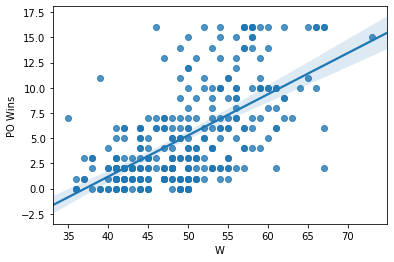

In [25]:
import seaborn as sns

y = finalDataClean['PO Wins']
x = predictors['W']

sns.regplot(x, y)

Here we can clearly see that there is strong positive relationship.

Next, there is most likely a lot of collinearity among our predictors, let's deal with this. We can drop some some predictors right away that we know will have very strong collinearity. For example, wins, loss, and win % are all directly related, so we will just keep win percentage.

In [26]:
predictors = predictors.drop(['W', 'L'], axis = 1)

Now, for the rest of the variables we can plot a heatmap of the correlation matrix to see what kind of other collinearity there is.

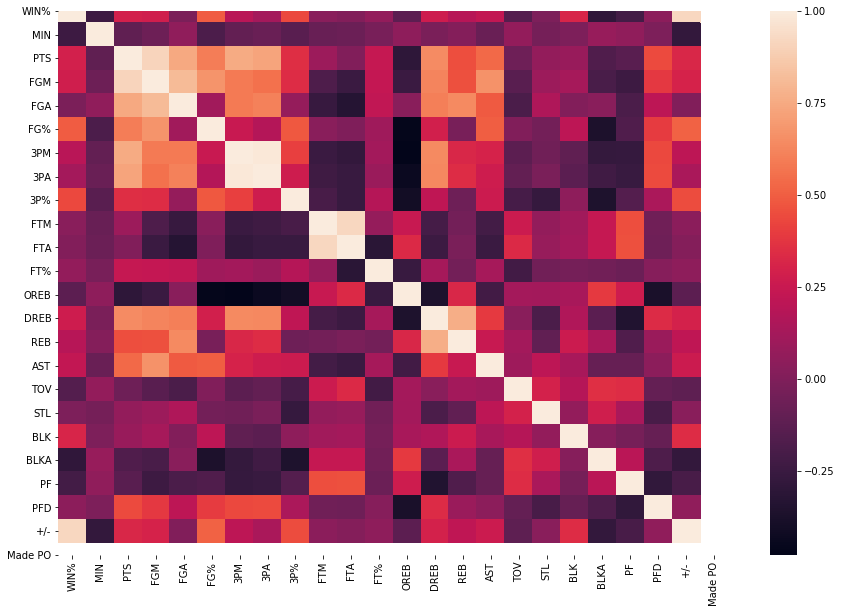

In [27]:
# https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec

corr = predictors.corr()

fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr)

We can see, as predicted, that there is a lot of collinearity between predictors. In order to account for this we need to choose ML models that handle collinearity well like Random Forrest and Principal Component Analysis.

We will also standardize the data to make it cleaner.

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(predictors)
predictors = scaler.transform(predictors)

## Models

For our models we have chosen to use Random Forrest, Boosting, and Principal Component Analysis. We will also use a train and test set data to test our predictions

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(predictors, y, test_size=0.40)

### Random Forrest

Random Forrests are well equipped for handling collinearity among predictors, so we have decided to use it. For the Random Forrest we will use sci-kit learn's RandomForestRegressor.

In [31]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [32]:
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

0.9087673987574132
0.3945629370753953


Looks like our model is probably overfitting. Let's try some hyperparameter tuning. To do hyperparameter tuning we will use sklearn's GridSearchCV

In [33]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor()

parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# acc_scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(rf, parameters)
grid_obj = grid_obj.fit(X_train, y_train)

rf = grid_obj.best_estimator_
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=3, min_weight_fraction_leaf=0.0,
                      n_estimators=9, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [34]:
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

0.6316296835200659
0.42339776413371083


### Boosting

We will use XGBoost for our boosting model

In [45]:
import xgboost as xgb

param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'

xgb_model = xgb.XGBRegressor(objective='reg:squarederror').fit(X_train, y_train)

In [46]:
print(xgb_model.score(X_train, y_train))
print(xgb_model.score(X_test, y_test))

0.9581017190208552
0.26490352240199344


In [49]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

clf = GridSearchCV(xgb_model,
                   {'max_depth': [2,3],
                    'n_estimators': [20, 50,100]
                   })
clf.fit(X_train,y_train)
print(clf.best_score_)
print(clf.best_params_)

xgb_model_best = clf.best_estimator_
xgb_model_best.fit(X_train, y_train)

0.3494071337637862
{'max_depth': 3, 'n_estimators': 20}


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=20,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [50]:
print(xgb_model_best.score(X_train, y_train))
print(xgb_model_best.score(X_test, y_test))

0.6988935738643485
0.32311476663752103


It appears that our Random Forrest does better than XGBoost. XGBoost is most likely overfitting.